# Part 1: Stitching pairs of images

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from pathlib import Path
from skimage.io import imread as _imread
from skimage.color import rgb2gray


def imread(filename: str, as_gray: bool = False):
    """Read image data for this part."""
    path = Path("part1") / filename
    im = _imread(path)
    if as_gray and (im.ndim == 3):
        return rgb2gray(im)
    else:
        return im


In [91]:
from skimage.feature.util import FeatureDetector, DescriptorExtractor
from skimage.transform import resize
from scipy.ndimage import rank_filter, gaussian_laplace


class fSIFT(FeatureDetector, DescriptorExtractor):
    """
    Args:
        min_sigma: 
        max_sigma:
        sigma_ratio:
        border (int): Image border distance, keypoints within the border are ignored. 
    """

    def __init__(
        self,
        min_sigma=1,
        max_sigma=50,
        n_sigma=16,
        threshold=0.1,
        harris_k=0.04,
        border=16,
        n_keypoints=500,
    ):
        self.min_sigma = min_sigma
        self.max_sigma = max_sigma
        self.n_sigma = n_sigma

        self.threshold = threshold

        self.border = border

        self.n_keypoints = n_keypoints
        self.harris_k = harris_k

        self.keypoints = None
        self.scales = None
        self.responses = None
        self.orientations = None
        self.descriptors = None

    def _laplacian_pyramid(self, image, max_layer, downscale, sigma):
        shape0, sigma0 = image.shape, sigma
        for _ in range(max_layer):
            image_laplacian = gaussian_laplace(image, sigma0, truncate=6)
            image_laplacian = resize(image_laplacian, shape0)
            yield image_laplacian * sigma0 ** 2, sigma

            out_shape = np.ceil(np.array(im.shape) / downscale)
            image = resize(image, out_shape)
            sigma *= downscale

    def _blob_log(self, image, min_sigma=1, max_sigma=50, n_sigma=10, threshold=0.2):
        sigma_list = np.logspace(np.log10(min_sigma), np.log10(max_sigma), n_sigma)
        downscale = sigma_list[1] / sigma_list[0]
        scale_space, sigma_list = zip(
            *list(
                self._laplacian_pyramid(
                    image, max_layer=n_sigma, downscale=downscale, sigma=sigma_list[0]
                )
            )
        )

        # we are working with minimums
        scale_space = -np.stack(scale_space, axis=-1)
        sigma_list = np.array(sigma_list)

        fig, ax = plt.subplots(1, n_sigma, figsize=(15, 5))
        for i in range(n_sigma):
            ax[i].imshow(scale_space[..., i], cmap="gray")
        plt.show()

        # non-maximal suppresion along each scale
        scale_space_nms = rank_filter(
            scale_space, -1, footprint=np.ones((3,) * (scale_space.ndim - 1) + (1,))
        )
        scale_space_nms = np.max(scale_space_nms, axis=-1)
        scale_space[scale_space < scale_space_nms[..., np.newaxis]] = 0

        # DEBUG
        print(
            f"[nms], min(ss)={np.min(scale_space_nms)}, max(ss)={np.max(scale_space_nms)}"
        )
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.imshow(scale_space_nms, cmap="gray")

        # intensity filter
        y, x, s = (scale_space > threshold).nonzero()
        # build keypoint coordinate
        keypoints = np.vstack([y, x])

        # remove keypoints too close to borders
        keypoints_mask = self._mask_border_keypoints(
            scale_space_nms.shape, keypoints, self.border
        )
        # keypoints, s = keypoints[:, keypoints_mask], s[keypoints_mask]

        # DEBUG save scale list for later
        return keypoints, s, sigma_list

    def _mask_border_keypoints(self, image_shape, keypoints, distance):
        """
        Mask coordinates that are within certain distance from the border.
        
        Args:
            TBD

        Returns:
            TBD

        Reference:
            skimage.feature.util._mask_border_keypoints
        """
        rows, cols = image_shape
        mask = (
            ((distance - 1) < keypoints[0, :])
            & (keypoints[0, :] < (rows - distance + 1))
            & ((distance - 1) < keypoints[1, :])
            & (keypoints[1, :] < (cols - distance + 1))
        )
        return mask

    def _harris_pyramid(self, image, sigma_list):
        pass

    def detect(self, image):
        """
        Detect keypoints in image.
        
        Args:
            image (2D array): Input image.

        Result:
            TBD
        """

        keypoints, s, sigma_list = self._blob_log(
            image, self.min_sigma, self.max_sigma, self.n_sigma, self.threshold
        )

        # TODO return scale space pyramid
        # TODO extract descriptor based on layer

        # turn scale index to sigma, and back to radius
        r = np.array(sigma_list[s], dtype=float) * np.sqrt(2)

        self.keypoints = np.vstack([keypoints, r])
        print(self.keypoints[:, :4])

    def extract(self, image, keypoints):
        """
        Extract feature descriptors in image for given keypoints.
        
        Args:
            image (2D array): Input image.
            keypoints ((N, 2) array): Keypoint locations as (row, col).
        """


In [3]:
from matplotlib.patches import Circle

im = imread("butterfly.jpg", as_gray=True)

detector = SIFT(min_sigma=2, max_sigma=32, n_sigma=5, threshold=0.4)
detector.detect(im)

cy, cx, r = detector.keypoints
print(f"len(blobs)={len(r)}")

fig, ax = plt.subplots(figsize=(15, 6))
ax.set_aspect("equal")
ax.imshow(im, cmap="gray")
for x, y, r in zip(cx, cy, r):
    circ = Circle((x, y), r, color="r", fill=False)
    ax.add_patch(circ)
plt.xlim(0, 100)
plt.ylim(175, 275)


NameError: name 'SIFT' is not defined

In [3]:
import cv2 as cv
from skimage.feature.util import FeatureDetector, DescriptorExtractor
from skimage.util import img_as_ubyte


class SIFT(FeatureDetector, DescriptorExtractor):
    """Wrapper class for OpenCV to use scikit-image detector-extractor."""

    def __init__(
        self,
        n_features=100,
        n_octave_layers=3,
        contrast_threshold=0.04,
        edge_threshold=10,
        sigma=1.6,
    ):
        self.detector = cv.SIFT_create(
            nfeatures=n_features,
            nOctaveLayers=n_octave_layers,
            contrastThreshold=contrast_threshold,
            edgeThreshold=edge_threshold,
            sigma=sigma,
        )

        self.keypoints = None
        self.descriptors = None

    def detect(self, image):
        # cv only takes in 8U
        image = img_as_ubyte(image)
        self.keypoints_ = self.detector.detect(image)

        # extract relevant info from cv structure
        self.keypoints = np.array([keypoint.pt[::-1] for keypoint in self.keypoints_])

    def extract(self, image, keypoints=None):
        if keypoints is not None:
            raise NotImplementedError(f"'keypoints' has no effect, using cached result")

        # cv only takes in 8U
        image = img_as_ubyte(image)
        _, self.descriptors = self.detector.compute(image, self.keypoints_)


In [4]:
from scipy.spatial.distance import cdist


def swap_by(v, cond):
    v[cond, 0], v[cond, 1] = v[cond, 1], v[cond, 0]
    return v


def ubcmtach(desc1, desc2, threshold):
    """
    Matches two sets of SIFT descriptors.append
    
    This function uses the algorithm suggested by D. Lowe to reject matches that are too ambiguous.
    
    Args:
        desc1
        desc2 
        threshold (float)
    """
    dist2 = cdist(desc1, desc2, metric="sqeuclidean")

    # find 1st and 2nd closest match distance
    index_closest = np.argpartition(dist2, 2)[:, :2]
    dist_closest = np.take_along_axis(dist2, index_closest, axis=-1)
    # sort in each partition
    need_swap = dist_closest[:, 0] > dist_closest[:, 1]
    index_closest = swap_by(index_closest, need_swap)
    dist_closest = swap_by(dist_closest, need_swap)

    # compare ratio
    index_closest_mask = dist_closest[:, 0] * threshold < dist_closest[:, 1]

    matches = [
        (m0, m1)
        for m0, (m1, mask) in enumerate(zip(index_closest[:, 0], index_closest_mask))
        if mask
    ]
    matches = np.array(matches)

    return matches, dist_closest[index_closest_mask, 0]


In [39]:
from skimage.measure.fit import BaseModel


class HomographyModel(BaseModel):
    def estimate(self, data) -> bool:
        """
        Estimate homography model from data.

        Args:
            data ((N, 4) array): N points in a 2D space, arrange in (x1, y1, x2, y2).

        Returns:    
            bool: True if model sucessfully estimates.
        """
        n = len(data)
        p1 = data[:, :2]
        p2 = data[:, 2:]

        A1 = np.hstack(
            [
                p1,
                np.ones((n, 1)),
                np.zeros((n, 3)),
                -p2[:, 0][:, np.newaxis] * p1,
                -p2[:, 0][:, np.newaxis],
            ]
        )

        A2 = np.hstack(
            [
                np.zeros((n, 3)),
                p1,
                np.ones((n, 1)),
                -p2[:, 1][:, np.newaxis] * p1,
                -p2[:, 1][:, np.newaxis],
            ]
        )

        A = np.empty((2 * n, A1.shape[-1]), dtype=int)
        A[0::2, :] = A1
        A[1::2, :] = A2

        u, s, vh = np.linalg.svd(A, full_matrices=False)

        # save the H
        self.params = np.reshape(vh[-1, :], (3, 3))

        # TODO return false if SVD comes out with an exception
        return True

    def residuals(self, data):
        """
        Determine residuals of data to model.

        Args:
            data ((N, 4) array):
        """
        n = len(data)
        p1 = data[:, :2]
        p2 = data[:, 2:]

        p2_fit = self.predict(p1)
        # calculate residuals
        residuals = np.hypot(*(p2_fit - p2).T)

        return residuals

    def predict(self, data):
        """
        Predict x-y coordinates using the estimated model.

        Args:
            data ((N, 2) array):
        """
        n = len(data)

        data = np.hstack([data, np.ones((n, 1))])
        data_fit = np.matmul(data, self.params.T)
        # convert back from homogeneous coordinate
        data_fit = data_fit[:, :-1] / data_fit[:, -1][:, np.newaxis]

        return data_fit

def ransac(
    data,
    model_class,
    min_samples,
    residual_threshold,
    max_trials=100,
    random_state=None,
):
    """
    RANSAC

    Args:
        data ((N, 2) array): 
        model_class :
        min_samples (int): Minimum number of data points to fit the model.
        residual_threshold (float): Maximum distance for a data point to be classified 
            as an inlier.
        max_trials (int, optional): Maximum number of iterations for RANSAC.
        random_State ({None, int, `numpy.random.Generator`}, optional): A seed to 
            initialize the BitGenerator.
    """
    n_samples = len(data)

    # model for this dataset, following skimage.measure.fit.BaseModel
    model = model_class()

    random_state = np.random.default_rng(random_state)

    best_inliers_num = 0
    best_residuals_sum = np.inf
    best_inliers = []

    for i_trial in range(max_trials):
        # select subset, forbit duplicate item
        sampling_mask = random_state.choice(n_samples, min_samples, replace=False)
        samples = data[sampling_mask, :]

        success = model.estimate(samples)
        if not success:
            # fail to fit for some reason
            continue
        residuals = np.abs(model.residuals(data))

        inliers = residuals < residual_threshold
        residuals_sum = np.sum(residuals ** 2)

        inliers_num = np.count_nonzero(inliers)

        if (
            # more inliers
            (inliers_num > best_inliers_num)
            # same number of inliers, but less residuals sum
            or (
                (inliers_num == best_inliers_num)
                and (residuals_sum < best_residuals_sum)
            )
        ):
            best_inliers = inliers
            best_residuals_sum = residuals_sum
            best_inliers_num = inliers_num

            # TODO early stop conditions

    if best_inliers.any():
        print(f".. best_residual_sum={best_residuals_sum:.6f}")
        print(f".. best_inliers_num={best_inliers_num}")
        
        # estimate the model with all inliers
        data_inliers = data[best_inliers, :]
        model.estimate(data_inliers)
    else:
        model = None
        best_inliers = None
        
    return model, best_inliers


1000 keypoints
1000 keypoints
[ubcmatch] 116 matches
.. best_residual_sum=10135422.545761
.. best_inliers_num=57
[ransac] 57 matches
[[    0.             0.        ]
 [  800.             0.        ]
 [  800.           398.        ]
 [    0.           398.        ]
 [    0.             0.        ]
 [-3720.133172   -1393.60082567]
 [  354.73506531     4.36126729]
 [  310.39663276   425.57297319]
 [-2972.61097536   915.56917726]
 [-3720.133172   -1393.60082567]]
output_shape=[4521 2310]
[[-1.82228110e-03  1.03555835e-04  9.36446111e-01]
 [-4.46515716e-04 -1.63799962e-03  3.50802515e-01]
 [-1.52255707e-06 -1.93884306e-07 -2.51723814e-04]]


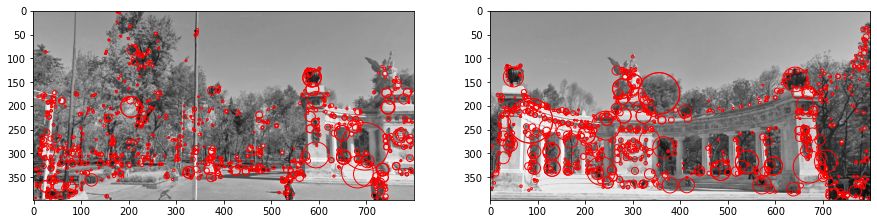

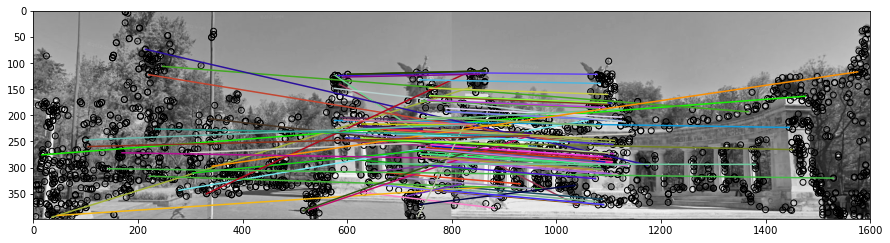

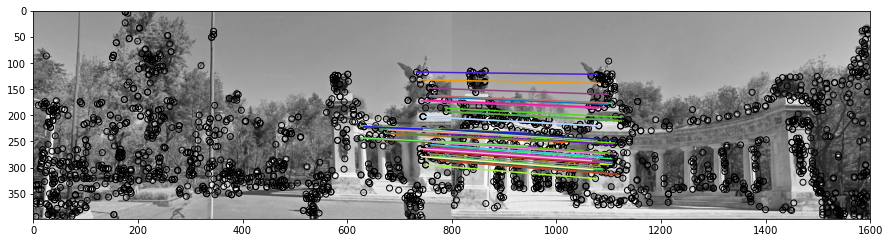

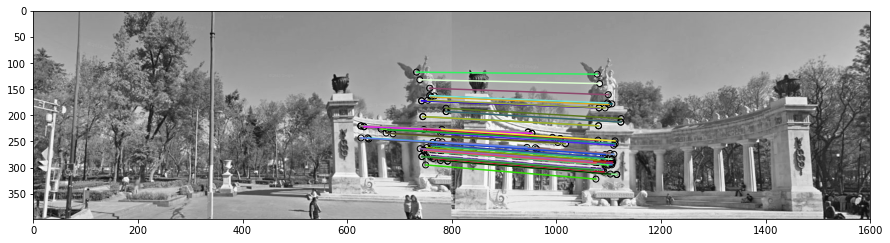

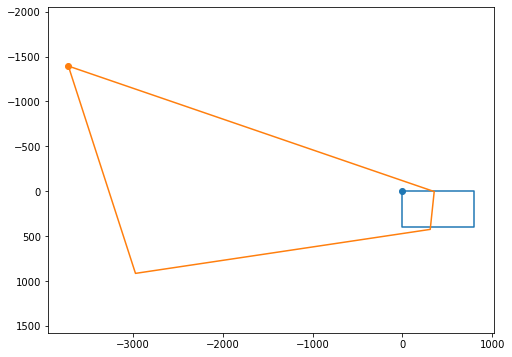

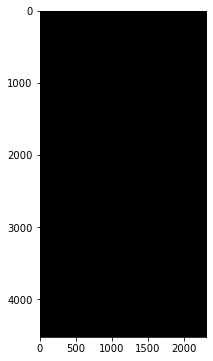

In [64]:
# test SIFT
from matplotlib.patches import Circle
from skimage.feature import plot_matches
from skimage.transform import warp, EuclideanTransform, ProjectiveTransform

images = [imread(f"{name}.jpg", as_gray=True) for name in ("left", "right")]

detector = SIFT(n_features=1000)

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
keypoints = []
descriptors = []
for i, image in enumerate(images):
    detector.detect(image)
    keypoints.append(detector.keypoints)
    print(f"{len(detector.keypoints)} keypoints")

    detector.extract(image)
    descriptors.append(detector.descriptors)

    ax[i].set_aspect("equal")
    ax[i].imshow(image, cmap="gray")
    for (y, x), raw in zip(detector.keypoints, detector.keypoints_):
        circ = Circle((x, y), raw.size, color="r", fill=False)
        ax[i].add_patch(circ)

matches, score = ubcmtach(descriptors[0], descriptors[1], 1.5)
print(f"[ubcmatch] {len(matches)} matches")

# DEBUG
fig, ax = plt.subplots(figsize=(15, 5))
plot_matches(ax, images[0], images[1], keypoints[0], keypoints[1], matches)

# build data array for RANSAC
m1 = keypoints[0][matches[:, 0], ::-1]
m2 = keypoints[1][matches[:, 1], ::-1]
data = np.hstack([m1, m2])
# run RANSAC
model, inliers = ransac(
    data, HomographyModel, min_samples=4, residual_threshold=10, max_trials=1000
)
print(f"[ransac] {np.count_nonzero(inliers)} matches")

# DEBUG
matches = matches[inliers, :]
fig, ax = plt.subplots(figsize=(15, 5))
plot_matches(ax, images[0], images[1], keypoints[0], keypoints[1], matches)

# calculate target match
m1, m2 = m1[inliers, :], m2[inliers, :]
m2_fit = model.predict(m1)
fig, ax = plt.subplots(figsize=(15, 5))
plot_matches(
    ax, images[0], images[1], m1[:, ::-1], m2_fit[:, ::-1], np.array([(i, i) for i in range(len(m1))])
)

# build output coordinate for each transformed image
ny, nx = images[1].shape
extent0 = np.vstack([(0, 0), (nx, 0), (nx, ny), (0, ny), (0, 0),])
extents = [extent0, model.predict(extent0)]

# DEBUG
fig, ax = plt.subplots(figsize=(8, 6))
ax.invert_yaxis()
# reference
xs, ys = zip(*extent0)
ax.plot(xs, ys)
ax.scatter(xs[0], ys[0])
# warped
xs, ys = zip(*extents[1])
ax.plot(xs, ys)
ax.scatter(xs[0], ys[0])

ax.axis("equal")

extents = np.vstack(extents)
# determine the final output size
extent_max, extent_min = np.max(extents, axis=0), np.min(extents, axis=0)
print(extents)
shape = np.ceil(extent_max - extent_min).astype(int)
print(f"output_shape={shape}")
# reference image need to sheift `extent_min`
offset = EuclideanTransform(translation=extent_min)
H = ProjectiveTransform(model.params)

print(model.params)


im_warp = np.stack(
    [
        warp(images[0], (H + offset).inverse, output_shape=shape, cval=0),
        warp(images[1], (offset).inverse, output_shape=shape, cval=0)
    ],
    axis=-1,
)
im_warp = np.mean(im_warp, axis=-1)

fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(im_warp, cmap="gray")



In [120]:
# build matrix
p1 = [(448,67),(602,129),(362,392),(483,494)]
p2 = [(386,78),(552,78),(386,453),(552,453)]

x1 = np.array(p1)
x2 = np.array(p2)

# flip to follow (x, y) convention
x1 = x1[:, ::-1]
x2 = x2[:, ::-1]
n = len(x1)

B1 = np.hstack([
    -x1, 
    -np.ones((n, 1)), 
    np.zeros((n, 3)),
    x2[:, 0][:, np.newaxis] * x1, 
    x2[:, 0][:, np.newaxis]
])

B2 = np.hstack([
    np.zeros((n, 3)),
    -x1, 
    -np.ones((n, 1)), 
    x2[:, 1][:, np.newaxis] * x1, 
    x2[:, 1][:, np.newaxis]
])

B = np.empty((2*n, B1.shape[-1]), dtype=int)
B[0::2, :] = B1
B[1::2, :] = B2

x = np.hstack([x1, x2])
print(x)
print(x.shape)

model = HomographyModel()
model.estimate(x)
r = model.residuals(x)
print(f'residuals={r}')

H = model.params

A = np.hstack([
    x1, 
    np.ones((n, 1))
])
x2p = np.matmul(A, H)
x2p = x2p[:, :-1] / x2p[:, -1][:, np.newaxis]

print(x2)
print(x2p)


[[ 67 448  78 386]
 [129 602  78 552]
 [392 362 453 386]
 [494 483 453 552]]
(4, 4)
(4, 4)
(4, 2)
residuals=[[7.10542736e-12 6.50857146e-11]
 [1.39976919e-11 5.84350346e-11]
 [7.59428076e-11 6.67341737e-11]
 [6.92352842e-11 1.08116183e-10]]
[[ 78 386]
 [ 78 552]
 [453 386]
 [453 552]]
[[ 78. 386.]
 [ 78. 552.]
 [453. 386.]
 [453. 552.]]


In [ ]:
# Provided code - nothing to change here


def plot_inlier_matches(ax, img1, img2, inliers):
    """
    Plot the matches between two images according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :inliers: x,y in the first image and x,y in the second image (Nx4)
    """
    res = np.hstack([img1, img2])
    ax.set_aspect("equal")
    ax.imshow(res, cmap="gray")

    ax.plot(inliers[:, 0], inliers[:, 1], "+r")
    ax.plot(inliers[:, 2] + img1.shape[1], inliers[:, 3], "+r")
    ax.plot(
        [inliers[:, 0], inliers[:, 2] + img1.shape[1]],
        [inliers[:, 1], inliers[:, 3]],
        "r",
        linewidth=0.4,
    )
    ax.axis("off")


# Usage:
# fig, ax = plt.subplots(figsize=(20,10))
# plot_inlier_matches(ax, img1, img2, computed_inliers)


In [6]:
# See assignment page for the instructions!
